# 첫번째 필사

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) 
# matplotlib의 기본 scheme 말고 seaborn을 세팅하고 일일이 graph의 font size를 지정할 필요가 없습니다.

import missingno as msno 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 프로세스 
---- 
1. 데이터셋 확인 - null data 존재
2. 탐색적 데이터 분석(exploratory data analysis) - 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인합니다.
   시각화 툴을 통해 insight를 얻습니다.
3. feature engineering - 모델의 성능을 높일 수 있도록 feature 들을 engineering합니다. one-hot encoding,class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 합니다.
4. model 만들기 - sklearn 을 사용해 모델을 만듭니다. 파이썬 머신러닝을 할 때는 sklearn을 사용하면 수많은 알고리즘을 일관된 문법으로 사용할 수 있습니다. 물론 딥러닝을 위해 tensorflow,pytorch 등을 사용할 수 도 있습니다. 
5. 모델 학습 및 예측 - trainset 을 가지고 모델을 학습시킨 후, tsetset을 가지고 prediction을 합니다. 
6. 모델 평가 - 예측 성능이 원하는 수준인지 판단합니다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라집니다. 학습된 모델이 어떤 것을 학습하였는지 확인해봅시다.

## 데이터셋 확인 

- 파이썬에서 테이블화 된 데이터를 다루는 데 가장 최적화되어 있으며, 많이 쓰이는 라이브러리는 Pandas 입니다. 
- 우리는 pandas 를 사용하여 데이터셋의 간단한 통계적 분석부터, 복잡한 처리들을 간단한 메소드를 사용하여 해낼 수 있습니다. 
- 파이썬으로 데이터 분석을 한다고 한다면 반드시 능숙해져야 할 라이브러리니, 여러 커널들을 공부하시면서 사용법에 익숙해지도록 반복 또 반복하시리 권장합니다. 
- 캐글에서 데이터셋은 보통 train, testset 으로 나뉘어 있습니다.

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train.head()

우리가 다루는 문제에서 feature는 Pclass, Age, SibSp, Parch, Fare이며, 예측하려는 target label은 Survived 입니다.

- pandas dataframe 에는 describe() 메소드가 있는데, 이를 쓰면 각 feature 가 가진 통계치들을 반환해줍니다.

In [ ]:
df_train.describe()

In [ ]:
df_test.describe()

In [ ]:
for col in df_train.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum()/df_train[col].shape[0]))
    print(msg)

In [ ]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum()/df_test[col].shape[0]))
    print(msg)

- Train, Test set에서 Age(둘다 약 20%), Cabin(둘다 약 80%), Embarked(Train만 0.22%) Null data가 존재!!

- MANO라는 라이브러리를 사용하면 null data의 존재를 더 쉽게 볼 수 있습니다.

In [ ]:
msno.matrix(df=df_train.iloc[:,:],figsize=(8,8),color=(0.5,0.5,0.9))

In [ ]:
msno.bar(df=df_train.iloc[:,:], figsize=(8,8),color = (0.5,0.5,0.9))

In [ ]:
msno.bar(df=df_test.iloc[:,:],figsize=(8,8),color=(0.8,0.5,0.9))

## Target label 확인 

- target label이 어떤 distribution을 가지고 있는 지 확인해봐야합니다.
- 지금 같은 binary classification 문제의 경우에서, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있습니다. 

In [ ]:
f, ax = plt.subplots(1,2,figsize=(18,8))

df_train['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot('Survived', data=df_train,ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()


# Exploratory data analysis

- 본격적인 데이터 분석! 
- 시각화 라이브러리는 matplotlib,seaborn,plotly 등이 있습니다. 특정 목적에 맞는 소스코드를 정리해두어 필요할때마다 참고하면 편하다.

## Pclass 

- 먼저 Pclass는 ordinal, 서수형 데이터입니다. 카테고리이면서, 순서가 있는 데이터 타입입니다.
- 먼저 Pclass에 따른 생존률의 차이를 살펴보겠습니다. 엑셀의 피벗 파트와 유사한 작업을 하게 되는데, pandas dataframe에서는 groupby를 사용하면 쉽게 할 수 있습니다. 또한, pivot이라는 메소드도 있습니다.
- 'Pclass','Survived' 를 가져온 후, pclass로 묶습니다. 그러고 나면 각 pclass 마다 0,1이 count가 되는데, 이를 평균내면 각 pclass 별 생존률이 나옵니다. 
- 아래와 같이 count()를 하면, 각 class 에 몇명이 있는지 확인할 수 있으며, sum()을 하면, 216 명중 생존한 (survived=1)의 총합을 주게 됩니다.

In [ ]:
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index=True).count()

In [ ]:
df_train[['Pclass','Survived']].groupby(['Pclass'], as_index = True).sum()

- pandas 의 crosstab 을 사용하면 좀 더 위 과정을 좀 더 수월하게 볼 수 있습니다.

In [ ]:
pd.crosstab(df_train['Pclass'],df_train['Survived'],margins=True).style.background_gradient(cmap='summer_r')

Grouped 객체에 mean()을 하게 되면, 각 클래스별 생존률을 얻을 수 있습니다.

In [ ]:
df_train[['Pclass','Survived']].groupby(['Pclass'],as_index=True).mean().sort_values(by='Survived',ascending=False).plot.bar()

- 보다시피, Pclass가 좋을수록 생존률이 높다! 

- 좀 더 보기 쉽게 그래프를 그려보겠습니다. seaborn의 countplot을 이용하면, 특정 label에 따른 개수를 확인해볼 수 있습니다.

In [ ]:
y_position = 1.02
f, ax = plt.subplots(1,2, figsize=(18,8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'],ax = ax[0])
ax[0].set_title('Number of Passengers By Pclass',y = y_position)
ax[0].set_ylabel('Count')
sns.countplot('Pclass',hue='Survived',data=df_train,ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y = y_position)
plt.show()

## Sex

- 이번에는 성별로 생존률이 어떻게 달라지는 지 확인해보겠습니다. 
- 마찬가지로 pandas groupby 와 seaborn countplot 을 사용해서 시각화해봅시다.

In [ ]:
f, ax = plt.subplots(1,2,figsize=(18,8))
df_train[['Sex','Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot('Sex', hue='Survived', data=df_train,ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

- 여자가 생존률이 높음

In [ ]:
df_train[['Sex','Survived']].groupby(['Sex'],as_index=False).mean().sort_values(by='Survived',ascending=False)

In [ ]:
pd.crosstab(df_train['Sex'],df_train['Survived'],margins=True).style.background_gradient(cmap='summer_r')

- Pclass 와 마찬가지로, Sex 도 예측 모델에 쓰일 중요한 feature 임을 알 수 있습니다

## Both Sex and Pclass

- 이번에는 Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는 지 확인해 봅시다
- seaborn 의 factorplot 을 이용하면, 손쉽게 3개의 차원으로 이루어진 그래프를 그릴 수 있습니다.

In [ ]:
sns.factorplot('Pclass','Survived',hue='Sex',data=df_train, size=6, aspect=1.5)

- 모든 클래스에서 female 이 살 확률이 male 보다 높은 걸 알 수 있습니다.
- 또한 남자, 여자 상관없이 클래스가 높을 수록 살 확률 높습니다.
- 위 그래프는 hue 대신 column 으로 하면 아래와 같아집니다

In [ ]:
sns.factorplot(x='Sex', y='Survived', col='Pclass', data=df_train, satureation=.5, size=9, aspect=1)

## Age
이번에는 Age feature 를 살펴봅시다.

In [ ]:
print('제일 나이가 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))

In [ ]:
# 생존에 따른 Age의 histogram 을 그려보겠습니다.
fig, ax = plt.subplots(1,1,figsize=(9,5))
sns.kdeplot(df_train[df_train['Survived']==1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived']==0]['Age'],ax=ax)
plt.legend(['Survived==1','Survived==0'])
plt.show()

In [ ]:
# 생존자 중에 어린 경우가 많음! 

# Age distribution withing classes
plt.figure(figsize=(8,6))
df_train['Age'][df_train['Pclass']==1].plot(kind='kde')
df_train['Age'][df_train['Pclass']==2].plot(kind='kde')
df_train['Age'][df_train['Pclass']==3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class','2nd Class','3rd Class'])

- Class 가 높을 수록 나이 많은 사람의 비중이 커짐

- 나이대가 변하면서 생존률이 어떻게 되는 지 보려고 합니다.
- 나이범위를 점점 넓혀가며, 생존률이 어떻게 되는지 한번 봅시다.

In [ ]:
cummulate_survival_ratio = []
for i in range(1,80):
    cummulate_survival_ratio.append(df_train[df_train['Age']<i]['Survived'].sum()/len(df_train[df_train['Age']<i]['Survived']))
    
plt.figure(figsize=(7,7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age',y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0~x)')
plt.show()


- 보시다시피, 나이가 어릴 수록 생존률이 확실히 높은것을 확인할 수 있습니다.
- 우리는 이 나이가 중요한 feature 로 쓰일 수 있음을 확인했습니다.

## Pclass, Sex, Age

- 지금까지 본, Sex, Pclass, Age, Survived 모두에 대해서 보고싶습니다. 이를 쉽게 그려주는 것이 seaborn 의 violinplot 입니다.
- x 축은 우리가 나눠서 보고싶어하는 case(여기선 Pclass, Sex) 를 나타내고, y 축은 보고 싶어하는 distribution(Age) 입니다.

In [ ]:
f, ax = plt.subplots(1,2,figsize=(18,8))
sns.violinplot("Pclass","Age",hue="Survived",data = df_train, scale='count',split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("Sex","Age",hue="Survived",data = df_train, scale='count',split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

- 왼쪽 그림은 Pclass 별로 Age의 distribution 이 어떻게 다른지, 거기에 생존여부에 따라 구분한 그래프입니다.
- 오른쪽 그림도 마찬가지 Sex, 생존에 따른 distribution 이 어떻게 다른지 보여주는 그래프입니다.
- 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 한것을 볼 수 있습니다.
- 오른쪽 그림에서 보면, 명확히 여자가 생존을 많이 한것을 볼 수 있습니다.
- 여성과 아이를 먼저 챙긴 것을 볼 수 있습니다.

# Embarked
- Embarked 는 탑승한 항구를 나타냅니다.
- 위에서 해왔던 것과 비슷하게 탑승한 곳에 따르 생존률을 보겠습니다.

In [ ]:
f,ax = plt.subplots(1,1,figsize=(7,7))
df_train[['Embarked','Survived']].groupby(['Embarked'],as_index = True).mean().sort_values(by='Survived',ascending=False).plot.bar(ax=ax)

- 보시다시피, 조금의 차이는 있지만 생존률은 좀 비슷한 거 같습니다. 그래도 C가 제일 높군요.
- 모델에 얼마나 큰 영향을 미칠지는 모르겠지만, 그래도 사용하겠습니다.
- 사실, 모델을 만들고 나면 우리가 사용한 feature 들이 얼마나 중요한 역할을 했는지 확인해볼 수 있습니다. 이는 추후에 모델을 만들고 난 다음에 살펴볼 것입니다.
- 다른 feature 로 split 하여 한번 살펴보겠습니다

In [ ]:
f,ax = plt.subplots(2,2,figsize=(20,15))
sns.countplot('Embarked',data = df_train,ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passengers Boarded')
sns.countplot('Embarked',hue='Sex',data=df_train,ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived',data=df_train,ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax= ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure(1) - 전체적으로 봤을 때, S 에서 가장 많은 사람이 탑승했습니다.
- Figure(2) - C와 Q 는 남녀의 비율이 비슷하고, S는 남자가 더 많습니다.
- Figure(3) - 생존확률이 S 경우 많이 낮은 걸 볼 수 있습니다. (이전 그래프에서 봤었습니다)
- Figure(4) - Class 로 split 해서 보니, C가 생존확률이 높은건 클래스가 높은 사람이 많이 타서 그렇습니다. S는 3rd class 가 많아서 생존확률이 낮게 나옵니다.


## Family - SibSp(형제 자매) + Parch(부모, 자녀)

- SibSp 와 Parch를 합하면 Family가 될 것입니다. Family로 합쳐서 분석해봅시다.

In [4]:
df_train['FamilySize']= df_train['SibSp']+ df_train['Parch']+1 # 자신을 포함해야되므로 1을 더합니다.
df_test['FamilySize']= df_test['SibSp'] + df_train['Parch']+1 #자신을 포함해야 하니 1을 더합니다.

In [5]:
print("Maximum size of Family: ",df_train['FamilySize'].max())
print("Minimum size of Family: ",df_train['FamilySize'].min())

Maximum size of Family:  11
Minimum size of Family:  1


- FamilySize 와 생존의 관계를 한번 살펴봅시다

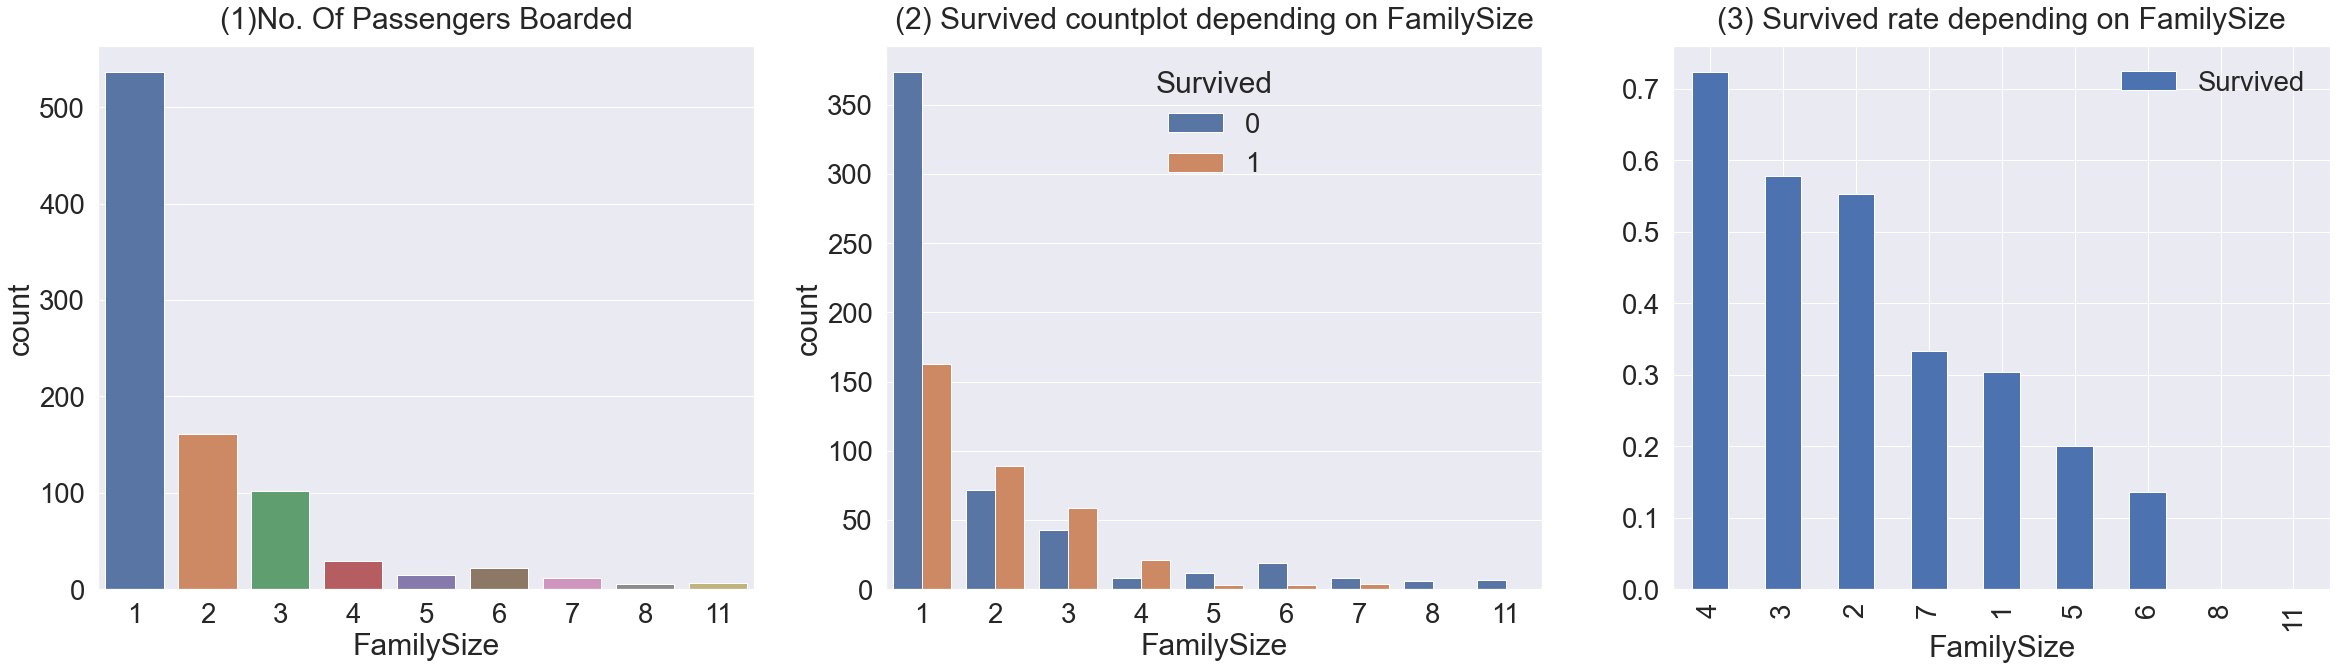

In [6]:
f,ax = plt.subplots(1,3,figsize=(40,10))
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1)No. Of Passengers Boarded', y= 1.02)

sns.countplot('FamilySize',hue='Survived',data=df_train,ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize',y=1.02)

df_train[['FamilySize','Survived']].groupby(['FamilySize'],as_index=True).mean().sort_values(by='Survived',ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure (1) - 가족크기가 1~11까지 있음을 볼 수 있습니다. 대부분 1명이고 그 다음으로 2, 3, 4명입니다.
- Figure (2), (3) - 가족 크기에 따른 생존비교입니다. 가족이 4명인 경우가 가장 생존확률이 높습니다. 가족수가 많아질수록, (5, 6, 7, 8, 11) 생존확률이 낮아지네요. 가족수가 너무 작아도(1), 너무 커도(5, 6, 8, 11) 생존 확률이 작네요. 3~4명 선에서 생존확률이 높은 걸 확인할 수 있습니다.

## Fare

- Fare 는 탑승요금이며, contious feature 입니다. 한번 histogram 을 그려보겠습니다.

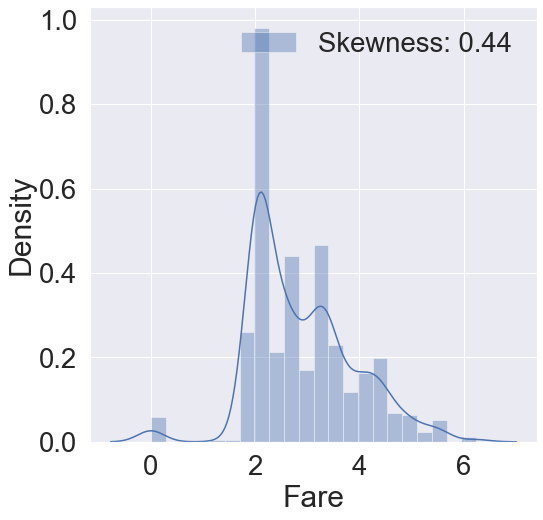

In [3]:
fig,ax = plt.subplots(1,1,figsize=(8,8))
g = sns.distplot(df_train['Fare'],color='b',label='Skewness: {:.2f}'.format(df_train['Fare'].skew()),ax=ax)
g = g.legend(loc='best')

- 보시다시피, distribution이 매우 비대칭인 것을 알 수 있습니다.(high skewness). 만약 이대로 모델에 넣어준다면 자칫 모델이 잘못 학습할 수도 있습니다. 몇개 없는 outlier 에 대해서 너무 민감하게 반응한다면, 실제 예측 시에 좋지 못한 결과를 부를 수 있습니다.
- outlier의 영향을 줄이기 위해 Fare 에 log 를 취하겠습니다.
- 여기서 우리는 pandas 의 유용한 기능을 사용할 겁니다. dataFrame 의 특정 columns 에 공통된 작업(함수)를 적용하고 싶으면 아래의 map, 또는 apply 를 사용하면 매우 손쉽게 적용할 수 있습니다.
- 우리가 지금 원하는 것은 Fare columns 의 데이터 모두를 log 값 취하는 것인데, 파이썬의 간단한 lambda 함수를 이용해 간단한 로그를 적용하는 함수를 map 에 인수로 넣어주면, Fare columns 데이터에 그대로 적용이 됩니다. 매우 유용한 기능이니 꼭 숙지하세요!

### 중요한 내용!!! (DataFrame에 map,lambda 활용)

In [ ]:
df_test.loc[df_test.Fare.isnull(),'Fare'] = df_test['Fare'].mean() # Testset에 있는 nan value를 평균값으로 치환합니다.

df_train['Fare'] = df_train['Fare'].map(lambda i:np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
g = sns.distplot(df_train['Fare'],color='b',label='Skewness : {:.2f}'.format(df_train['Fare'].skew()),ax=ax)
g = g.legend(loc='best')
             

- log 를 취하니, 이제 비대칭성이 많이 사라진 것을 볼 수 있습니다.
- 우리는 이런 작업을 사용해 모델이 좀 더 좋은 성능을 내도록 할 수 있습니다.
- 사실 방금한 것은 feature engineering 에 들어가는 부분인데, 여기서 작업했습니다.
- 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature 들에 여러 조작을 가하거나, 새로운 feature를 추가하는 것을 feature engineering 이라고 하는데, 우리는 이제 그것을 살펴볼 것입니다.

## Cabin 

- 이 feature 는 NaN 이 대략 80% 이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지 않습니다. 
- 그러므로, 우리가 세우려는 모델에 포함시키지 않도록 하겠습니다. 


In [ ]:
df_train.head()

## Ticket 

- 이 feature는 NaN 값이 없습니다. 일단 String data가 어떤 작업들을 해주어야 실제 모델에 사용할 수 있는데 사실 아이디어가 필요합니다.

In [ ]:
df_train['Ticket'].value_counts()

- 보시다시피, ticket number 는 매우 다양합니다. 우리는 여기서 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까요?
> 아이디어 내보기

- 이 튜토리얼에서는 튜토리얼이니 일단 ticket 은 넘기도록 하겠습니다. 튜토리얼을 끝낸 후, 여러분의 모델의 성능을 향상시키기 위해 ticket 에서 정보를 이끌어내는 것도 좋겠네요!

# 튜토리얼 2 - Explratory data analysis, visualization, machine learning

In [7]:
import numpy as np 
import pandas as pd 
from pandas import Series
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 필자가 항상 쓰는 방법. Matplotlib의 기본 Scheme 말고
# seabortn Scheme 을 세팅하고, 일일이 graph 의 font size를 지정할 필요 없이 seaborn의 font_scale 을 사용하면 편합니다.

import plotly.offline as py 
import plotly.graph_objs as go 
import plotly.tools as tls 

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

In [8]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 
df_test['FamilySize'] = df_test['SibSp']+ df_test['Parch'] + 1 

df_test.loc[df_test.Fare.isnull(),'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)

# Feature Engineering

- 가장 먼저, dataset 에 존재하는 null data를 채우려고 합니다.
- 아무 숫자로 채울 수는 없고, null data 를 포함하는 feature 의 statistics 를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.
- null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분입니다.
- Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만아닐라 test 도 똑같이 적용해주어야 합니다. 잊지맙시다.

## Find Null 
### Fill Null in Age using title

- Age 에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics 를 사용해 보겠습니다.
- 영어에서는 Miss, Mrr, Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title 이 들어가게 되는데 이를 사용해보겠습니다.
- pandas series 에는 data 를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title 을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다

In [20]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
# 한 글자 아무거나 + .
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')  #lets extract the Salutations

- pandas 의 crosstab 을 이용하여 우리가 추출한 Initial 과 Sex 간의 count 를 살펴봅시다.

In [21]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 table 을 참고하여, 남자, 여자가 쓰는 initial 을 구분해 보겠습니다. replace 메소드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해줍니다.

-------

In [22]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [23]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


<AxesSubplot:xlabel='Initial'>

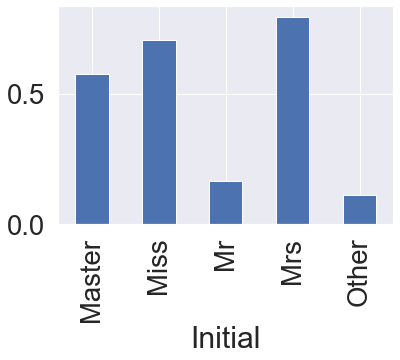

In [24]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 이제 본격적으로 Null 을 채울 것입니다. null data 를 채우는 방법은 정말 많이 존재합니다. statistics 를 활용하는 방법도 있고, null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics 를 활용하는 방법을 사용할 것입니다.
- 여기서 statistics 는 train data 의 것을 의미합니다. 우리는 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test 의 null data 를 채워줘야 합니다.

In [25]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용해 Null value 를 채우도록 하겠습니다.
- pandas dataframe 을 다룰 때에는 boolean array를 이용해 indexing 하는 방법이 참으로 편리합니다.
- 아래 코드 첫줄을 해석하자면, isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다 입니다.
- loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.



In [26]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age']=33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age']=36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age']=5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age']=22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age']=46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age']= 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age']=46


- 여기선 간단하게 Null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재합니다
```
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
```

- 이 외에도 다른 캐글러들의 커널을 보며 여러 참신한 아이디어를 살펴보세요!


## Fill Null in Embarked 

In [27]:
print('Embarked has',sum(df_train['Embarked'].isnull()),'Null values')

Embarked has 2 Null values


- Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채우겠습니다.
- dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True 로 하면 df_train 에 fillna 를 실제로 적용하게 됩니다

In [28]:
df_train['Embarked'].fillna('S',inplace=True)

## Change Age(continuous to categorical)

- Age는 continuous feature 입니다. Age를 몇개의 group으로 나누어 category화 시켜줄 수도 있습니다. continuous를 categorical로 바꾸면, 자칫 information loss가 생길 수도 있습니다만, 다양한 방법을 소개하는 것이 목적이므로 진행하겠습니다.

- 방법) DataFrame의 indexing 방법인 loc을 사용하여 직접 해줄 수 있고, 아니면 apply를 사용해 함수를 넣어줄 수 있습니다. 
- 첫번째로 loc 를 사용하는 방법입니다. loc 는 자주쓰게 되므로 그 사용법을 숙지하세요
- 나이는 10살 간격으로 나누겠습니다.

In [34]:
df_train['Age_cat']=0
df_train.loc[df_train['Age']<10,'Age_cat']=0
df_train.loc[(10<= df_train['Age']) & (df_train['Age']<20),'Age_cat'] = 1
df_train.loc[(20<=df_train['Age']) & (df_train['Age']< 30),'Age_cat'] = 2 
df_train.loc[(30<=df_train['Age']) & (df_train['Age']<40),'Age_cat'] = 3
df_train.loc[(40<=df_train['Age']) & (df_train['Age']<50),'Age_cat'] = 4
df_train.loc[(50<=df_train['Age']) & (df_train['Age']<60),'Age_cat'] = 5
df_train.loc[(60<=df_train['Age']) & (df_train['Age']<70),'Age_cat']=6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0 
df_test.loc[df_test['Age']<10, 'Age_cat']=0
df_test.loc[(10<=df_test['Age']) & (df_test['Age']<20),'Age_cat'] = 1
df_test.loc[(20<=df_test['Age']) & (df_test['Age']<30),'Age_cat'] = 2 
df_test.loc[(30<=df_test['Age']) & (df_test['Age']<40),'Age_cat'] = 3
df_test.loc[(40<=df_test['Age']) & (df_test['Age']<50),'Age_cat'] = 4
df_test.loc[(50<=df_test['Age']) & (df_test['Age']<60),'Age_cat'] = 5 
df_test.loc[(60<=df_test['Age']) & (df_test['Age']<70),'Age_cat'] = 6
df_test.loc[70<=df_train['Age'],'Age_cat']=7

두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.
훨씬 수월합니다.

In [37]:
def category_age(x):
    if x<10:
        return 0
    elif x<20:
        return 1 
    elif x<30:
        return 2
    elif x<40:
        return 3
    elif x<50:
        return 4
    elif x<60:
        return 5
    elif x<70:
        return 6
    else:
        return 7
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

- 두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.
- 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [39]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ',(df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


In [42]:
df_train.drop(['Age','Age_cat_2'],axis=1,inplace=True)
df_test.drop(['Age'],axis=1,inplace=True)


## Change Initial, Embarked and Sex ( String to numerical)

- 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
- map method 를 가지고 간단히 할 수 있습니다.
- 사전 순서대로 정리하여 mapping 하겠습니다

In [43]:
df_train['Initial'] = df_train['Initial'].map({'Master':0,'Miss':1,'Mr':2,'Mrs':3,'Other':4})
df_test['Initial'] = df_test['Initial'].map({'Master':0,'Miss':1,'Mr':2,'Mrs':3,'Other':4})


- Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.
- 그러기 앞서서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있습니다.

In [44]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [45]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

-위 두 방법을 사용해 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있습니다. 이제 map을 사용해봅시다

In [46]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0,'Q':1,'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0,'Q':1,'S':2})

- 한번 Null 이 사라졌는지 확인해봅시다. Embarked Column만 가져온 것은 하나의 pandas의 Series 객체므로, isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 이것에 any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됩니다

In [47]:
df_train['Embarked'].isnull().any()

False

- Sex 도 Female, male 로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

In [48]:
df_train['Sex'] = df_train['Sex'].map({'female':0,'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0,'male':1})

- 여지껏 고생하셨습니다. 이제 각 feature 간의 상관관계를 한번 보려고 합니다. 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 아래와 같습니다.

In [ ]:
heatmap_data = df_train[['Survived','Pclass','Sex','Fare','Embarked','FamilySize','Initial','Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson ')